In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler as srs
import random
import matplotlib.pyplot as plt
from collections import Counter
import torch.optim as optim
use_cuda = True
import time
from torch.utils.data import DataLoader


In [2]:
dir = '/Users/endothermiic/Desktop/GitHub/APS360_Project/aps360dataset'
transform = transforms.Compose([transforms.ToTensor(),
         transforms.Resize((224, 224)), # images are either 450 * 600 or 1024 * 1024
                                # all resized to 224 * 224 for ResNet
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# transform input images to match requirements; load all images to all_data
all_data = torchvision.datasets.ImageFolder(dir, transform=transform)

In [74]:
all_data

Dataset ImageFolder
    Number of datapoints: 23344
    Root location: /Users/endothermiic/Desktop/GitHub/APS360_Project/aps360dataset
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [75]:
# use a set, random seed
torch.manual_seed(0)

# find 20% of len(all_data) for 20% test and val sets
test_size = int(len(all_data) * 0.04)

# remaining ~60% is left for training
train_size = int(len(all_data) * 0.12)

extra = len(all_data) - 2 * test_size - train_size

In [76]:
# randomly split the data into training, test and validation sets
train_data, val_data, test_data, extra = torch.utils.data.random_split(all_data,
  [train_size, test_size, test_size, extra])

# use Dataloader to allow for iteration (img, label) over a dataset
# same method used in previous labs
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True)

print("There are {0} images in training, ".format(len(train_loader)))
print("{0} images in validation and ".format(len(val_loader)))
print("{0} images in testing".format(len(test_loader)))

There are 2801 images in training, 
933 images in validation and 
933 images in testing


In [79]:
def get_counts(loader):
    # information from dataloader
    labels = [label for img, label in loader.dataset]

    # num / class counted
    counts = dict(Counter(labels))

    return counts

train_counts = get_counts(train_loader)
val_counts = get_counts(val_loader)
test_counts = get_counts(test_loader)

In [139]:
original_dataset = train_loader.dataset.dataset

In [140]:
class_names = original_dataset.classes

In [141]:
class_names

['bcc', 'bkl', 'mel', 'nv']

In [142]:
n = {idx: cls for cls, idx in original_dataset.class_to_idx.items()}

In [143]:
n

{0: 'bcc', 1: 'bkl', 2: 'mel', 3: 'nv'}

In [144]:
test_counts

{3: 619, 0: 177, 1: 136, 2: 235}

In [145]:
train_counts.keys()

dict_keys([3, 0, 1, 2])

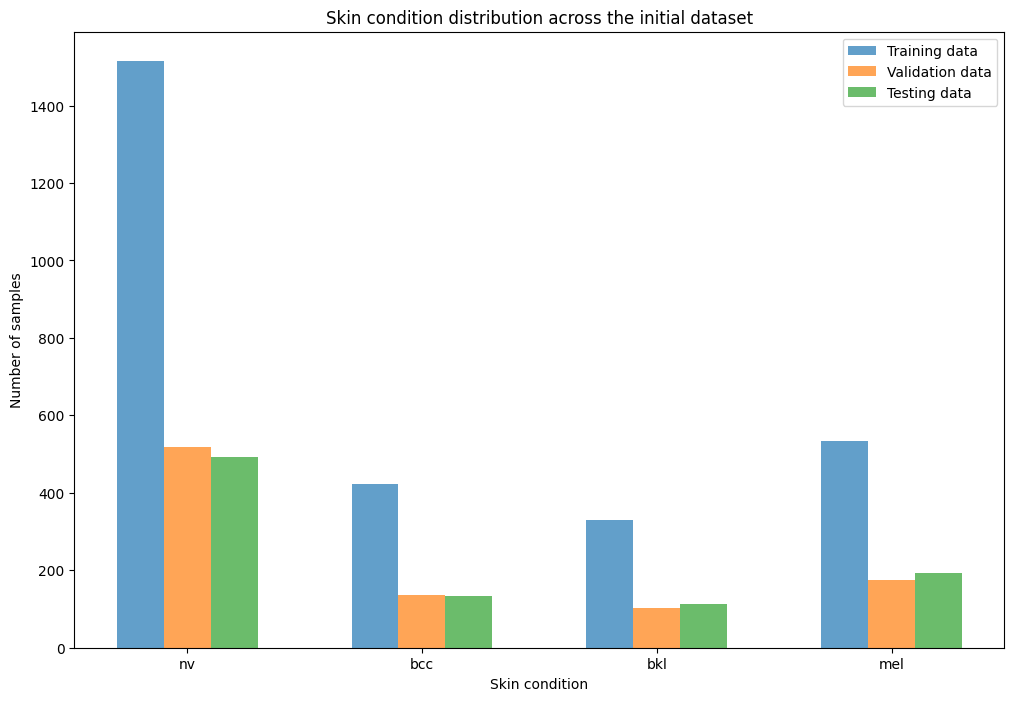

In [183]:
# Pre data augmentation 
labels = ['nv', 'bcc', 'bkl', 'mel']

def plot(train_counts, val_counts, test_counts, title):
    conditions = train_counts.keys()

    train_values = [train_counts.get(c, 0) for c in conditions]
    val_values = [val_counts.get(c, 0) for c in conditions]
    test_values = [test_counts.get(c, 0) for c in conditions]
    
    x = np.arange(len(conditions))
    width = 0.2 
    
    plt.figure(figsize=(12, 8))
    plt.bar(x - width, train_values, width, label='Training data', alpha=0.7)
    plt.bar(x, val_values, width, label='Validation data', alpha=0.7)
    plt.bar(x + width, test_values, width, label='Testing data', alpha=0.7)
    
    plt.xlabel('Skin condition')
    plt.ylabel('Number of samples')
    plt.title(title)
    plt.xticks(x, labels) # can confirm with swapping out conditions here
    plt.legend()
    
    plt.show()


plot(train_counts, val_counts, test_counts, "Skin condition distribution across the initial dataset")


In [7]:
conditions = train_counts.keys()
t_counts = [train_counts.get(c, 0) for c in conditions]
print(f"Training counts: {t_counts}")
v_counts = [val_counts.get(c, 0) for c in conditions]
print(f"Val counts: {v_counts}")
te_counts = [test_counts.get(c, 0) for c in conditions]
print(f"Test counts: {te_counts}")

Training counts: [1515, 423, 329, 534]
Val counts: [519, 137, 102, 175]
Test counts: [493, 133, 113, 194]


In [8]:
def augment(data, counts):
    max_count = max(counts)
    augments = [max_count - c for c in counts]

    # transforms for augmentation
    horiz = transforms.RandomHorizontalFlip()
    vert = transforms.RandomVerticalFlip()
    rot = transforms.RandomRotation(90)
    rot_1 = transforms.RandomRotation(270)

    
    augmented_data = []
    all_images = {i: [] for i in range(0, 3)}

    for img, label in data: 
        if label in range(0,3): # minority classes have labels 0, 1, 2
            all_images[label].append((img, label))

    for i in range(0, 3):
        images = all_images[i]
        
        for img, label in images:
            if augments[i + 1] <= 5: # initial class is majority class
                break
            augmented_data.append((horiz(img), label))
            augmented_data.append((vert(img), label))
            augmented_data.append((rot(img), label)) 
            augmented_data.append((rot_1(img), label))
            augments[i + 1] -= 4
            counts[i + 1] += 4
    
    full = data + augmented_data
    return full, counts

In [9]:
aug_test, test_counts = augment(test_data, te_counts)
aug_val, val_counts = augment(val_data, v_counts)
aug_train, train_counts = augment(train_data, t_counts)

In [255]:
i
val_loader = torch.utils.data.DataLoader(aug_val, shuffle=True)
test_loader = torch.utils.data.DataLoader(aug_test, shuffle=True)

In [264]:
# convert list to dict for visualization
def list_to_dict(counts):
    return {0: counts[1], 1: counts[2], 2: counts[3], 3: counts[0]}

test_dict = list_to_dict(test_counts)
val_dict = list_to_dict(val_counts)
train_dict = list_to_dict(train_counts)

In [256]:
train_counts = get_counts(train_loader) # can confirm results with counter
val_counts = get_counts(val_loader)
test_counts = get_counts(test_loader)

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (37).

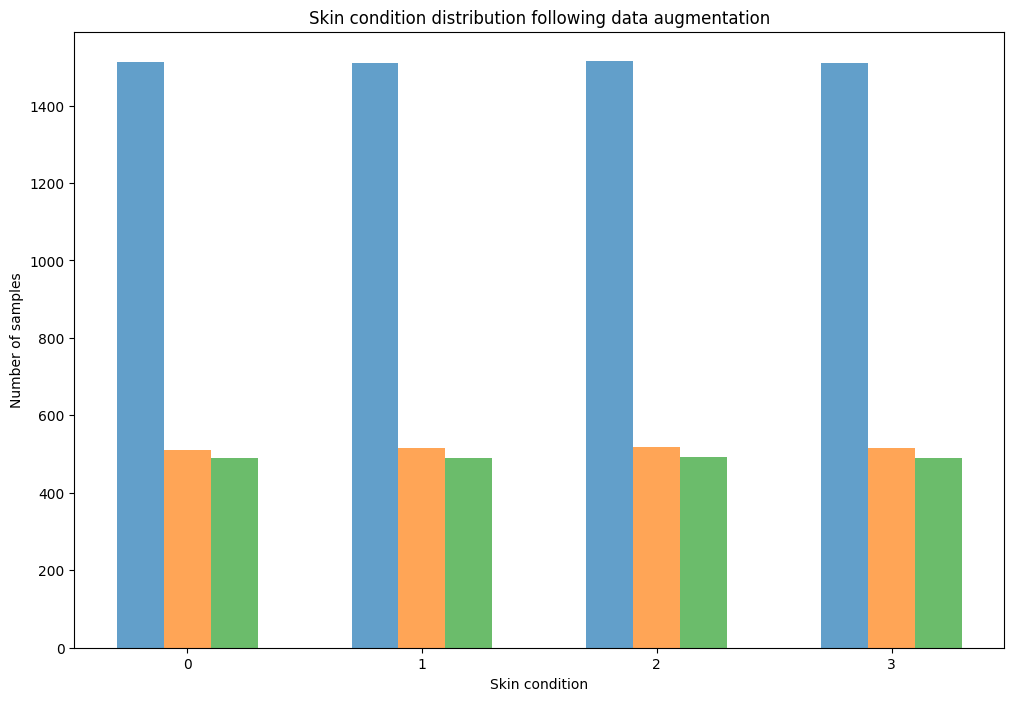

In [266]:
plot(train_dict, val_dict, test_dict, "Skin condition distribution following data augmentation")

# Model

In [11]:
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

In [12]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "cnn"
        # Input shape [128, 512, 7, 7] == [batch size, channels, feature map width, fm height]
        self.conv1 = nn.Conv2d(512, 128, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.cbam1 = CBAM(128)
        self.conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.cbam2 = CBAM(64)
        self.conv3 = nn.Conv2d(64, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.cbam3 = CBAM(32)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(32 * 7 * 7, 4)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.cbam1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.cbam2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.cbam3(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [147]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)


train_features, val_features, test_features = [], [], []

# Remove the final fully connected layer
model = nn.Sequential(*list(model.children())[:-2])
model.eval()  # Set model to evaluation mode

def get_features(loader, save):
    for imgs, labels in loader:
        with torch.no_grad():
            features = model(imgs)  # Shape: [batch_size, 512, 7, 7]
        save.append([features, labels])

# Example usage with train_loader, val_loader, test_loader
get_features(train_loader, train_features)
get_features(val_loader, val_features)
get_features(test_loader, test_features)


Using cache found in /Users/endothermiic/.cache/torch/hub/pytorch_vision_v0.10.0


In [148]:
class FeatureDataset(torch.utils.data.Dataset):
    def __init__(self, features):
        self.features = features

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature, label = self.features[idx]
        return feature.squeeze(), label

train_dataset = FeatureDataset(train_features)
val_dataset = FeatureDataset(val_features)
test_dataset = FeatureDataset(test_features)

In [267]:
### Trying again with another full dataset
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)


train_features_1, val_features_1, test_features_1 = [], [], []

# Remove the final fully connected layer
model = nn.Sequential(*list(model.children())[:-2])
model.eval()  # Set model to evaluation mode

def get_features(loader, save):
    for imgs, labels in loader:
        with torch.no_grad():
            features = model(imgs)  # Shape: [batch_size, 512, 7, 7]
        save.append([features, labels])

# Example usage with train_loader, val_loader, test_loader
get_features(train_loader, train_features_1)
get_features(val_loader, val_features_1)
get_features(test_loader, test_features_1)

Using cache found in /Users/endothermiic/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [268]:
class FeatureDataset(torch.utils.data.Dataset):
    def __init__(self, features):
        self.features = features

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature, label = self.features[idx]
        return feature.squeeze(), label

train_dataset_1 = FeatureDataset(train_features_1)
val_dataset_1 = FeatureDataset(val_features_1)
test_dataset_1 = FeatureDataset(test_features_1)

# Functions for training, accuracy

In [17]:
def get_accuracy(model, data, batch_size):
    correct = 0
    total = 0

    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1,keepdim = True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [178]:
def train(model, name, data, val_data=None, trial_num=0, batch_size=1, lr=0.01, num_epochs=10):
    torch.manual_seed(1000)

    if use_cuda and torch.cuda.is_available():
        model.cuda()

    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr, momentum=0.9, weight_decay=1e-4)

    iters, train_loss, val_loss, train_acc, val_acc = [], [], [], [], []


    start_time = time.time()

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in data_loader:
            #print(imgs.shape)
            #print(labels)
            #print("Image shape before: ", imgs.shape)
            #imgs = imgs.squeeze(0)
            if n % 4 == 0:
                transforms.RandomHorizontalFlip(imgs)
            elif n % 4 == 3:
                transforms.RandomVerticalFlip(imgs)
            elif n % 4 == 2:
                transforms.RandomRotation(270, imgs)
            elif n % 4 == 1:
                transforms.RandomRotation(90, imgs)
            labels = labels.squeeze()

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        for imgs, labels in val_loader:
            #print(imgs.shape)
            #print(labels)
            #print("Image shape before: ", imgs.shape)
            #imgs = imgs.squeeze(0)
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            labels = labels.squeeze()

            out = model(imgs)             # forward pass
            v_loss = criterion(out, labels) # compute the total loss


        # save the current training information
        iters.append(n)
        train_loss.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, data, batch_size=batch_size)) # compute training accuracy


        val_acc.append(get_accuracy(model, val_data, batch_size=batch_size))  # compute validation accuracy
        val_loss.append(float(v_loss)/batch_size)
        n += 1


        if val_data != None:
            print(f"Epoch {epoch + 1}: Train acc: {train_acc[-1]} | Validation acc: {val_acc[-1]}")
        else:
            print(f"Epoch {epoch + 1}: Train acc: {train_acc[-1]}")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time elapsed: {elapsed_time:.2f} s")
    model_path = "ModelSave/" + name
    torch.save(model.state_dict(), model_path)

    # plot
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.plot(iters, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    if val_data != None:
        print("Final Validation Accuracy: {}".format(val_acc[-1]))

# Model architecture

In [186]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "cnn"
        # Input shape [128, 512, 7, 7] == [batch size, channels, feature map width, fm height]
        self.conv1 = nn.Conv2d(512, 256, 5, padding=1)  # Output: [batch, 128, 7, 7]
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer : 256 * 4 * 4
        self.bn1 = nn.BatchNorm2d(256)
        self.cbam1 = CBAM(256)
        
        self.conv2 = nn.Conv2d(256, 64, 5, padding=1)  # Output: [batch, 128, 4, 4]
        self.bn2 = nn.BatchNorm2d(64)
        self.cbam2 = CBAM(64)
        
        self.dropout = nn.Dropout(0.6)

        self.fc = nn.Linear(576, 4)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.cbam1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.cbam2(x)
        
     
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = F.relu(self.fc(x)) # Fully connected layer
        return x
        

# Best run

Epoch 1: Train acc: 0.5487412961971077 | Validation acc: 0.5557341907824223
Epoch 2: Train acc: 0.5589180503481521 | Validation acc: 0.5712754555198285
Epoch 3: Train acc: 0.5717728976968398 | Validation acc: 0.5771704180064309
Epoch 4: Train acc: 0.5827530798071773 | Validation acc: 0.5836012861736335
Epoch 5: Train acc: 0.5977504017139796 | Validation acc: 0.6028938906752411
Epoch 6: Train acc: 0.613551151580075 | Validation acc: 0.6184351554126474
Epoch 7: Train acc: 0.629887520085699 | Validation acc: 0.627545551982851
Epoch 8: Train acc: 0.6440814140332084 | Validation acc: 0.6404072883172561
Epoch 9: Train acc: 0.6472951258703803 | Validation acc: 0.6468381564844587
Epoch 10: Train acc: 0.6574718800214248 | Validation acc: 0.6538049303322615
Epoch 11: Train acc: 0.6644349223352972 | Validation acc: 0.6655948553054662
Epoch 12: Train acc: 0.6722013926084628 | Validation acc: 0.6645230439442658
Epoch 13: Train acc: 0.6807712908409213 | Validation acc: 0.6714898177920686
Epoch 14: T

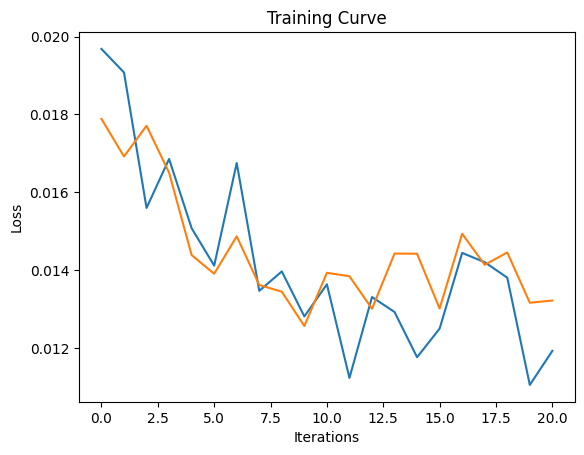

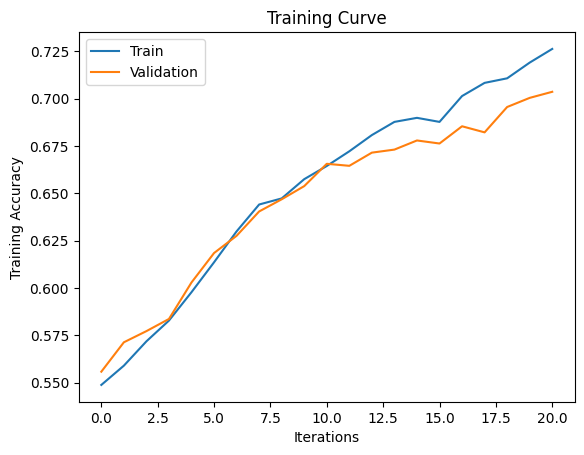

Final Training Accuracy: 0.726298875200857
Final Validation Accuracy: 0.7036441586280815


In [201]:
model_4 = CNNClassifier() # 7000 training images
train(model_4, "test_4", train_dataset, val_dataset, batch_size=64, lr=0.0001, num_epochs=21)


In [205]:
checkpoint = torch.load("ModelSave/test_4", map_location=torch.device('cpu'))
model_5.load_state_dict(checkpoint)

<All keys matched successfully>

Epoch 1: Train acc: 0.7289769683985002 | Validation acc: 0.7041800643086816
Epoch 2: Train acc: 0.7383502945902517 | Validation acc: 0.710075026795284
Epoch 3: Train acc: 0.7429030530262453 | Validation acc: 0.7165058949624866
Epoch 4: Train acc: 0.7447777182645956 | Validation acc: 0.7197213290460879
Epoch 5: Train acc: 0.7538832351365827 | Validation acc: 0.7202572347266881
Total time elapsed: 107.87 s


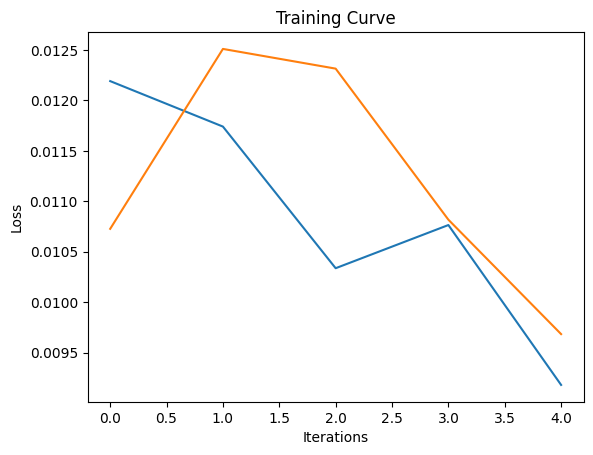

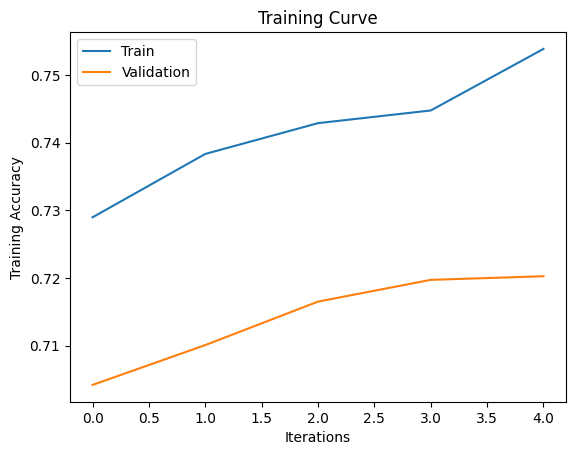

Final Training Accuracy: 0.7538832351365827
Final Validation Accuracy: 0.7202572347266881


In [206]:
train(model_5, "test_5", train_dataset, val_dataset, batch_size=64, lr=0.0001, num_epochs=5)

In [226]:
get_accuracy(model_5, test_dataset, 64)

0.7459807073954984

In [210]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [227]:
y_pred = []
batch_size = 64
for imgs, labels in torch.utils.data.DataLoader(test_dataset, batch_size=batch_size):
        outputs = model(imgs)
        predicted = torch.max(outputs, 1)
        y_pred.extend(predicted)

Epoch 1: Train acc: 0.4724094881398252 | Validation acc: 0.4709099950273496
Epoch 2: Train acc: 0.5263420724094882 | Validation acc: 0.5275982098458478
Epoch 3: Train acc: 0.5561797752808989 | Validation acc: 0.5517155643958229
Epoch 4: Train acc: 0.5916354556803995 | Validation acc: 0.5788165091994033
Epoch 5: Train acc: 0.6210986267166042 | Validation acc: 0.6106414719045251
Epoch 6: Train acc: 0.6415730337078651 | Validation acc: 0.6322725012431626
Epoch 7: Train acc: 0.6611735330836455 | Validation acc: 0.6466931874689209
Epoch 8: Train acc: 0.6823970037453183 | Validation acc: 0.6611138736946792
Epoch 9: Train acc: 0.6948813982521848 | Validation acc: 0.6827449030333168
Epoch 10: Train acc: 0.7262172284644195 | Validation acc: 0.6911984087518648
Epoch 11: Train acc: 0.7478152309612984 | Validation acc: 0.6911984087518648
Epoch 12: Train acc: 0.7710362047440699 | Validation acc: 0.7215315763301839
Epoch 13: Train acc: 0.7912609238451935 | Validation acc: 0.7187966185977126
Epoch 14

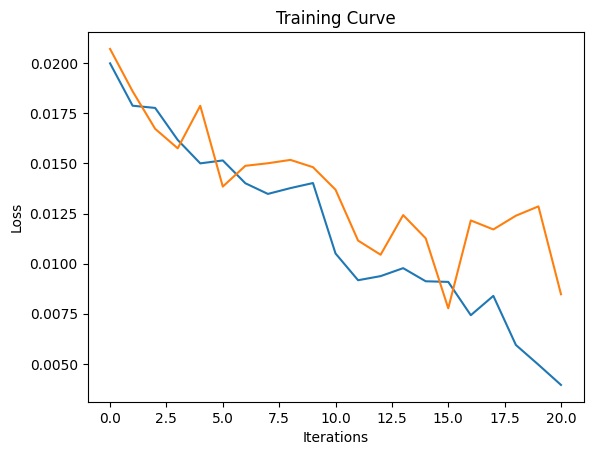

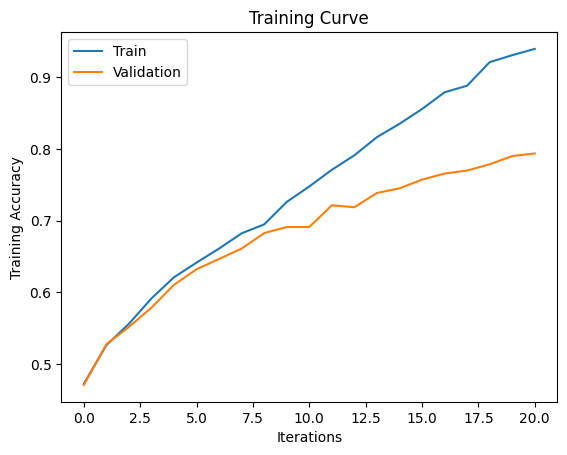

Final Training Accuracy: 0.9397003745318352
Final Validation Accuracy: 0.7938836399801094


In [274]:
model_6 = CNNClassifier() # 7000 training images
train(model_6, "test_6", train_dataset_1, val_dataset_1, batch_size=64, lr=0.0001, num_epochs=21)


Epoch 1: Train acc: 0.449812734082397 | Validation acc: 0.43485827946295375
Epoch 2: Train acc: 0.5213483146067416 | Validation acc: 0.5131775236200895
Epoch 3: Train acc: 0.565792759051186 | Validation acc: 0.5591745400298359
Epoch 4: Train acc: 0.5997503121098626 | Validation acc: 0.5964694181999005
Epoch 5: Train acc: 0.6320848938826467 | Validation acc: 0.625559423172551
Epoch 6: Train acc: 0.6439450686641698 | Validation acc: 0.6337642963699652
Epoch 7: Train acc: 0.6689138576779026 | Validation acc: 0.6529090004972651
Epoch 8: Train acc: 0.6886392009987515 | Validation acc: 0.6576330183988066
Epoch 9: Train acc: 0.7067415730337079 | Validation acc: 0.6750372948781701
Epoch 10: Train acc: 0.730087390761548 | Validation acc: 0.690949776230731
Epoch 11: Train acc: 0.7435705368289638 | Validation acc: 0.7038786673296867
Epoch 12: Train acc: 0.768039950062422 | Validation acc: 0.7093485827946295
Total time elapsed: 767.98 s


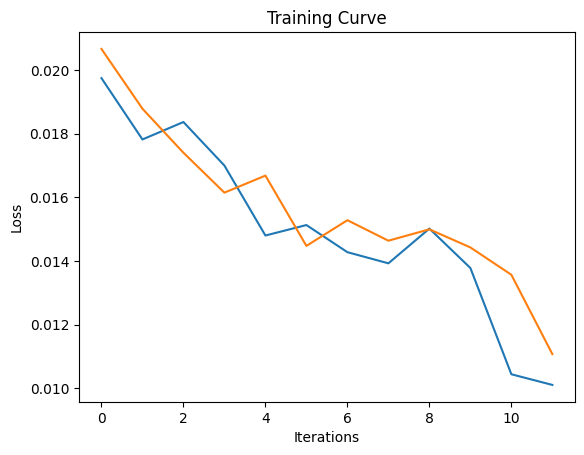

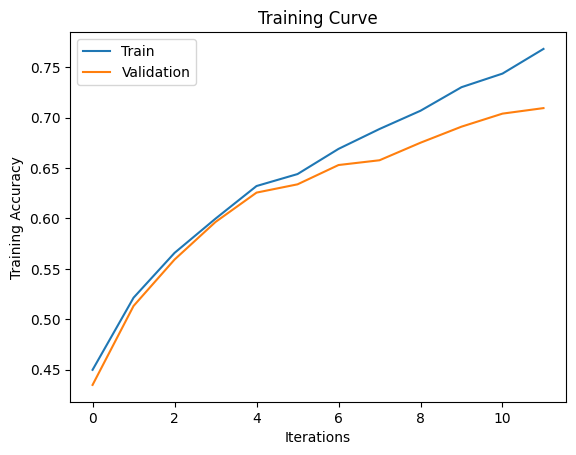

Final Training Accuracy: 0.768039950062422
Final Validation Accuracy: 0.7093485827946295


In [289]:
model_7 = CNNClassifier() # 7000 training images
train(model_7, "best_model", train_dataset_1, val_dataset_1, batch_size=64, lr=0.0001, num_epochs=12)


In [332]:
best_model = CNNClassifier()
checkpoint = torch.load("ModelSave/best_model", map_location=torch.device('cpu'))
best_model.load_state_dict(checkpoint)

<All keys matched successfully>

Epoch 1: Train acc: 0.7621722846441947 | Validation acc: 0.7093485827946295
Epoch 2: Train acc: 0.7690387016229713 | Validation acc: 0.7058677274987568
Epoch 3: Train acc: 0.7696629213483146 | Validation acc: 0.7143212332173048
Epoch 4: Train acc: 0.7647940074906368 | Validation acc: 0.7090999502734958
Epoch 5: Train acc: 0.7706616729088639 | Validation acc: 0.7100944803580308
Epoch 6: Train acc: 0.7681647940074906 | Validation acc: 0.713078070611636
Epoch 7: Train acc: 0.7730337078651686 | Validation acc: 0.712083540527101
Epoch 8: Train acc: 0.769538077403246 | Validation acc: 0.7048731974142218
Epoch 9: Train acc: 0.7744069912609238 | Validation acc: 0.71730482347091
Epoch 10: Train acc: 0.7725343320848939 | Validation acc: 0.7170561909497762
Epoch 11: Train acc: 0.76729088639201 | Validation acc: 0.7170561909497762
Epoch 12: Train acc: 0.7749063670411985 | Validation acc: 0.7140726006961711
Epoch 13: Train acc: 0.7737827715355805 | Validation acc: 0.7145698657384386
Epoch 14: Train

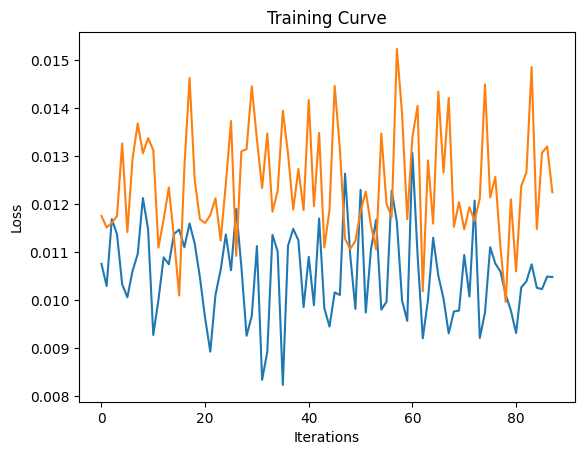

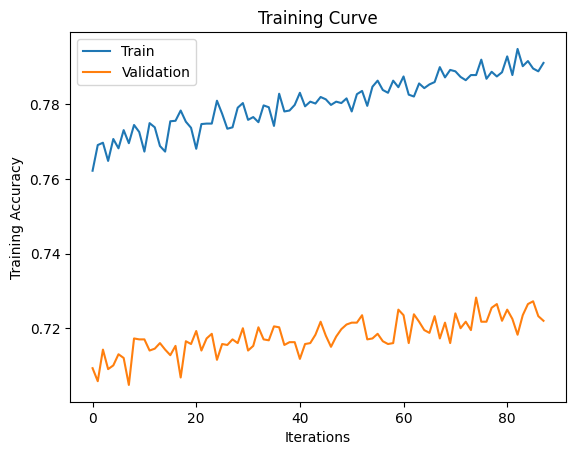

Final Training Accuracy: 0.7910112359550562
Final Validation Accuracy: 0.7220288413724515


In [342]:
train(best_model, "additional_epochs_best", train_dataset_1, val_dataset_1, batch_size=64, lr=0.000001, num_epochs=88)

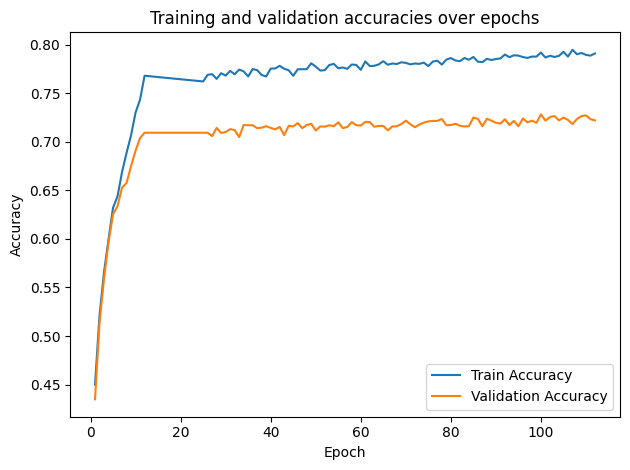

In [343]:
# Combined plots
import matplotlib.pyplot as plt

# Data for the first training run (Epoch 1 to 12)
epochs1 = list(range(1, 13))
train_acc1 = [
    0.449812734082397, 0.5213483146067416, 0.565792759051186, 
    0.5997503121098626, 0.6320848938826467, 0.6439450686641698, 
    0.6689138576779026, 0.6886392009987515, 0.7067415730337079, 
    0.730087390761548, 0.7435705368289638, 0.768039950062422
]
val_acc1 = [
    0.43485827946295375, 0.5131775236200895, 0.5591745400298359, 
    0.5964694181999005, 0.625559423172551, 0.6337642963699652, 
    0.6529090004972651, 0.6576330183988066, 0.6750372948781701, 
    0.690949776230731, 0.7038786673296867, 0.7093485827946295
]

# Data for the second training run (Epoch 1 to 88)
epochs2 = list(range(13, 101))
train_acc2 = [
    0.7621722846441947, 0.7690387016229713, 0.7696629213483146, 
    0.7647940074906368, 0.7706616729088639, 0.7681647940074906, 
    0.7730337078651686, 0.769538077403246, 0.7744069912609238, 
    0.7725343320848939, 0.76729088639201, 0.7749063670411985, 
    0.7737827715355805, 0.7687890137328339, 0.76729088639201, 
    0.7754057428214731, 0.7755305867665419, 0.7782771535580524, 
    0.7752808988764045, 0.7736579275905119, 0.768039950062422, 
    0.7746566791510612, 0.7747815230961298, 0.7747815230961298, 
    0.7808988764044944, 0.7774032459425718, 0.7734082397003745, 
    0.7737827715355805, 0.7790262172284644, 0.7802746566791511, 
    0.7757802746566792, 0.7765293383270911, 0.7751560549313359, 
    0.7796504369538078, 0.779151061173533, 0.7741573033707865, 
    0.7827715355805244, 0.7780274656679151, 0.7782771535580524, 
    0.7797752808988764, 0.7830212234706617, 0.7794007490636704, 
    0.780649188514357, 0.7801498127340823, 0.7818976279650437, 
    0.7812734082397004, 0.7797752808988764, 0.780649188514357, 
    0.7802746566791511, 0.7815230961298377, 0.7780274656679151, 
    0.7826466916354556, 0.7835205992509363, 0.779525593008739, 
    0.7846441947565543, 0.786267166042447, 0.7837702871410737, 
    0.7830212234706617, 0.786267166042447, 0.7845193508114856, 
    0.7873907615480649, 0.782521847690387, 0.7820224719101123, 
    0.785518102372035, 0.7842696629213484, 0.7852684144818977, 
    0.785892634207241, 0.7898876404494382, 0.7871410736579276, 
    0.7891385767790262, 0.7887640449438202, 0.7872659176029962, 
    0.7863920099875156, 0.787765293383271, 0.787765293383271, 
    0.7918851435705369, 0.7867665418227215, 0.7886392009987515, 
    0.7873907615480649, 0.7885143570536829, 0.7927590511860175, 
    0.787765293383271, 0.7947565543071161, 0.7901373283395755, 
    0.7915106117353309, 0.7895131086142322, 0.7887640449438202, 
    0.7910112359550562
]
val_acc2 = [
    0.7093485827946295, 0.7093485827946295, 0.7058677274987568, 0.7143212332173048, 
    0.7090999502734958, 0.7100944803580308, 0.713078070611636, 
    0.712083540527101, 0.7048731974142218, 0.71730482347091, 
    0.7170561909497762, 0.7170561909497762, 0.7140726006961711, 
    0.7145698657384386, 0.7160616608652411, 0.7143212332173048, 
    0.7128294380905023, 0.7153157633018399, 0.7068622575832919, 
    0.7165589259075087, 0.7158130283441074, 0.7192938836399801, 
    0.7140726006961711, 0.71730482347091, 0.7185479860765788, 
    0.7115862754848334, 0.7158130283441074, 0.7155643958229736, 
    0.7170561909497762, 0.7160616608652411, 0.7200397812033814, 
    0.7140726006961711, 0.7153157633018399, 0.7202884137245151, 
    0.7170561909497762, 0.7168075584286425, 0.720537046245649, 
    0.7202884137245151, 0.7155643958229736, 0.716310293386375, 
    0.716310293386375, 0.7118349080059672, 0.7158130283441074, 
    0.7160616608652411, 0.718299353555445, 0.7217802088513178, 
    0.7180507210343113, 0.7150671307807062, 0.7178020885131775, 
    0.7197911486822476, 0.7210343112879165, 0.7215315763301839, 
    0.7215315763301839, 0.7235206364992541, 0.7170561909497762, 
    0.71730482347091, 0.7185479860765788, 0.7165589259075087, 
    0.7158130283441074, 0.7160616608652411, 0.7250124316260567, 
    0.7235206364992541, 0.7160616608652411, 0.7237692690203879, 
    0.7217802088513178, 0.7195425161611139, 0.7187966185977126, 
    0.7232720039781203, 0.71730482347091, 0.7215315763301839, 
    0.7160616608652411, 0.7240179015415217, 0.7200397812033814, 
    0.7217802088513178, 0.7195425161611139, 0.7282446544007957, 
    0.7217802088513178, 0.7255096966683242, 0.7265042267528593, 
    0.7220288413724515, 0.7250124316260567, 0.722526106414719, 
    0.718299353555445, 0.7235206364992541, 0.7265042267528593, 
    0.7272501243162606, 0.7232720039781203, 0.7220288413724515, 
]

combined_epochs = epochs1 + [epoch + len(epochs1) for epoch in epochs2]
combined_train_acc = train_acc1 + train_acc2
combined_val_acc = val_acc1 + val_acc2

# Plot the training and validation accuracies

plt.plot(combined_epochs, combined_train_acc, label='Train Accuracy')
plt.plot(combined_epochs, combined_val_acc, label='Validation Accuracy')


# Label the axes and the plot
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracies over epochs')
plt.legend()
plt.tight_layout()

# Save the plot to a file (optional)
# plt.savefig('accuracy_plot.png')

# Show the plot
plt.show()


In [367]:
import torch
import numpy as np

# Lists to store true labels and predictions
all_labels = []
all_preds = []

# Disable gradient calculation
with torch.no_grad():
    for inputs, labels in torch.utils.data.DataLoader(test_dataset, batch_size=batch_size):  # Assuming test_loader yields (inputs, labels)
        
        # Forward pass
        outputs = model_6(inputs)
        
        # Get the predicted class (for classification)
        _, preds = torch.max(outputs, 1)
        
        # Append true labels and predictions
        all_labels.extend(labels.numpy())
        all_preds.extend(preds.numpy())

# Convert lists to numpy arrays
y_true = np.array(all_labels)
y_pred = np.array(all_preds)


In [346]:
get_accuracy(best_model, test_dataset_1, 64)

0.7904130545639979

In [348]:
get_accuracy(best_model, test_dataset, 64) 

0.737406216505895

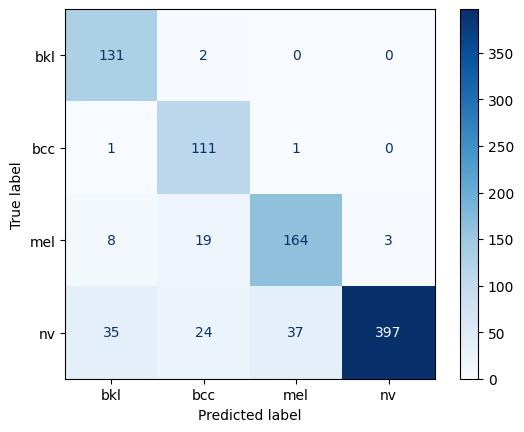

In [368]:
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['bkl', 'bcc', 'mel', 'nv'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [362]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = 2 * (precision * recall) / (precision + recall)

print("\nUsing sklearn's precision_score and recall_score:")
for i in range(4):
    print(f'Class {i} - Precision: {precision[i]:.2f}, Recall: {recall[i]:.2f}, F1: {f1[i]:.2f}')


Using sklearn's precision_score and recall_score:
Class 0 - Precision: 0.83, Recall: 0.88, F1: 0.85
Class 1 - Precision: 0.71, Recall: 0.71, F1: 0.71
Class 2 - Precision: 0.81, Recall: 0.69, F1: 0.75
Class 3 - Precision: 0.78, Recall: 0.85, F1: 0.81


Epoch 1: Train acc: 0.5344519814352017 | Validation acc: 0.564844587352626
Epoch 2: Train acc: 0.5619421635130311 | Validation acc: 0.5744908896034298
Epoch 3: Train acc: 0.5583720099964299 | Validation acc: 0.5852090032154341
Epoch 4: Train acc: 0.5662263477329526 | Validation acc: 0.5830653804930332
Epoch 5: Train acc: 0.5722956087111746 | Validation acc: 0.5755627009646302
Epoch 6: Train acc: 0.5847911460192788 | Validation acc: 0.5969989281886388
Epoch 7: Train acc: 0.5869332381292396 | Validation acc: 0.5959271168274384
Epoch 8: Train acc: 0.5962156372724027 | Validation acc: 0.6034297963558414
Epoch 9: Train acc: 0.6008568368439843 | Validation acc: 0.6120042872454448
Epoch 10: Train acc: 0.620492681185291 | Validation acc: 0.617363344051447
Epoch 11: Train acc: 0.6283470189218137 | Validation acc: 0.62486602357985
Epoch 12: Train acc: 0.6383434487682971 | Validation acc: 0.6377277599142551
Epoch 13: Train acc: 0.6551231702963227 | Validation acc: 0.6377277599142551
Epoch 14: Tra

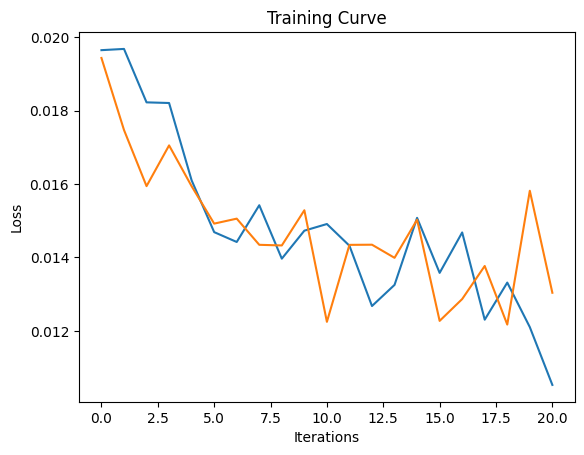

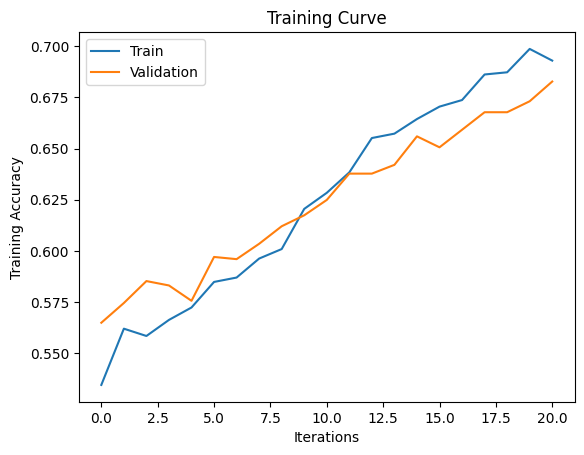

Final Training Accuracy: 0.6929667975722956
Final Validation Accuracy: 0.6827438370846731


In [193]:
model_3 = CNNClassifier() # 7000 training images
train(model_3, "test_3", train_dataset, val_dataset, batch_size=64, lr=0.00009, num_epochs=21)


## Other trials (do not use)

Epoch 1: Train acc: 0.3052481256694038 | Validation acc: 0.2958199356913183
Epoch 2: Train acc: 0.43698679043198857 | Validation acc: 0.4415862808145766
Epoch 3: Train acc: 0.5148161370938951 | Validation acc: 0.5401929260450161
Epoch 4: Train acc: 0.5355230274901821 | Validation acc: 0.5359056806002144
Epoch 5: Train acc: 0.579435915744377 | Validation acc: 0.6087888531618435
Epoch 6: Train acc: 0.5987147447340235 | Validation acc: 0.587352625937835
Epoch 7: Train acc: 0.6197786504819707 | Validation acc: 0.602357984994641
Epoch 8: Train acc: 0.6222777579435915 | Validation acc: 0.609860664523044
Epoch 9: Train acc: 0.6301320956801142 | Validation acc: 0.6280814576634512
Epoch 10: Train acc: 0.6504819707247411 | Validation acc: 0.6312968917470525
Epoch 11: Train acc: 0.6397715101749375 | Validation acc: 0.6302250803858521
Epoch 12: Train acc: 0.6511960014280614 | Validation acc: 0.632368703108253
Epoch 13: Train acc: 0.6561942163513032 | Validation acc: 0.6355841371918542
Epoch 14: Tr

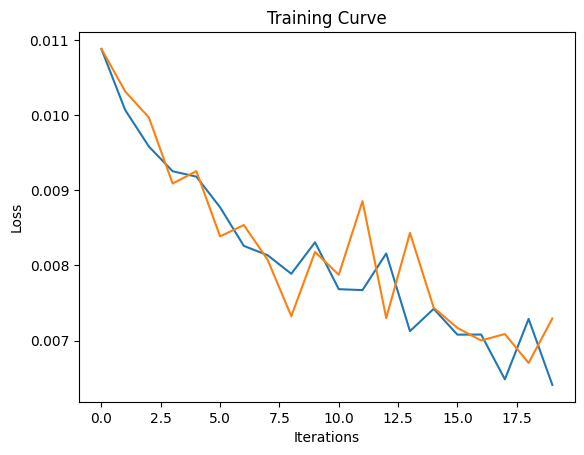

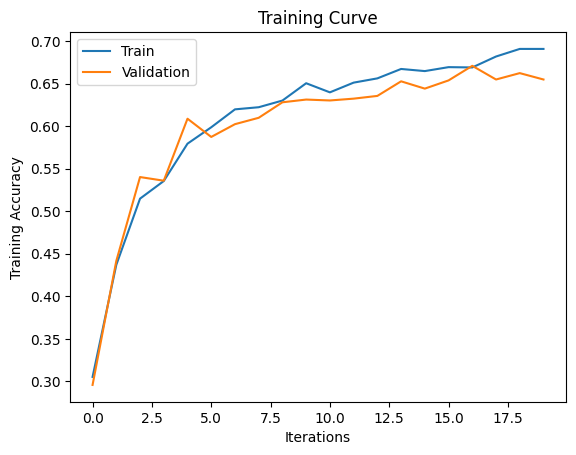

Final Training Accuracy: 0.6908247054623349
Final Validation Accuracy: 0.654876741693462


In [174]:
model = CNNClassifier() # 7000 training images
train(model, train_dataset, val_dataset, batch_size=128, lr=0.0001, num_epochs=20)

Epoch 1: Train acc: 0.5198143520171368 | Validation acc: 0.5241157556270096
Epoch 2: Train acc: 0.5722956087111746 | Validation acc: 0.5852090032154341
Epoch 3: Train acc: 0.5865762227775795 | Validation acc: 0.6012861736334405
Epoch 4: Train acc: 0.6019278828989647 | Validation acc: 0.609860664523044
Epoch 5: Train acc: 0.6151374509103892 | Validation acc: 0.6077170418006431
Epoch 6: Train acc: 0.6251338807568726 | Validation acc: 0.6130760986066452
Epoch 7: Train acc: 0.6358443413066762 | Validation acc: 0.6227224008574491
Epoch 8: Train acc: 0.6433416636915388 | Validation acc: 0.6441586280814576
Epoch 9: Train acc: 0.6658336308461263 | Validation acc: 0.6463022508038585
Epoch 10: Train acc: 0.6601213852195644 | Validation acc: 0.6613076098606645
Epoch 11: Train acc: 0.6754730453409497 | Validation acc: 0.6570203644158628
Epoch 12: Train acc: 0.6826133523741521 | Validation acc: 0.6602357984994641
Epoch 13: Train acc: 0.7026062120671189 | Validation acc: 0.654876741693462
Epoch 14: 

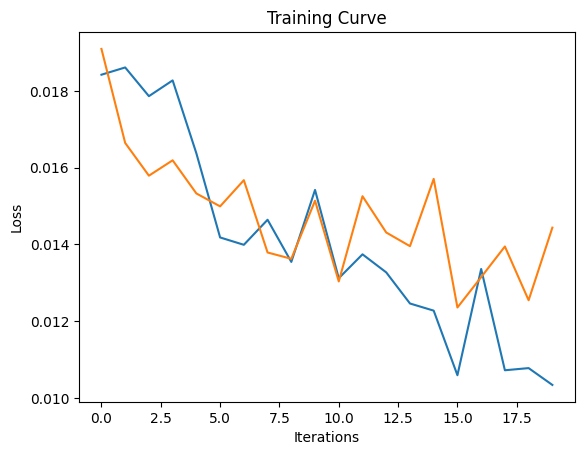

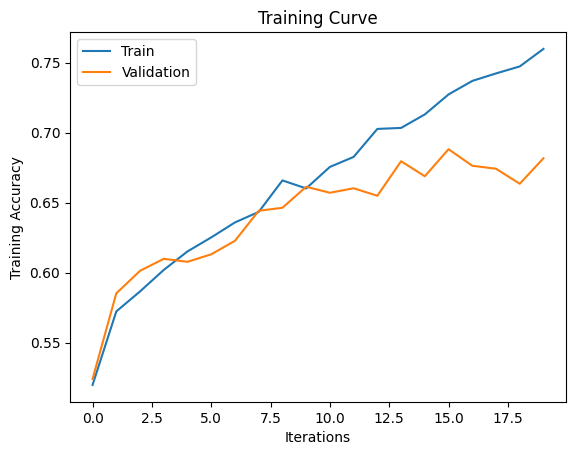

Final Training Accuracy: 0.7597286683327383
Final Validation Accuracy: 0.6816720257234726


In [172]:
model = CNNClassifier() # 7000 training images
train(model, train_dataset, val_dataset, batch_size=64, lr=0.0001, num_epochs=20)

Epoch 1: Train acc: 0.2656194216351303 | Validation acc: 0.25187566988210075
Epoch 2: Train acc: 0.4791146019278829 | Validation acc: 0.44694533762057875
Epoch 3: Train acc: 0.5797929310960371 | Validation acc: 0.5627009646302251
Epoch 4: Train acc: 0.605855051767226 | Validation acc: 0.5959271168274384
Epoch 5: Train acc: 0.6394144948232774 | Validation acc: 0.6216505894962486
Epoch 6: Train acc: 0.6436986790431989 | Validation acc: 0.6237942122186495
Epoch 7: Train acc: 0.6522670474830418 | Validation acc: 0.6452304394426581
Epoch 8: Train acc: 0.6511960014280614 | Validation acc: 0.6495176848874598
Epoch 9: Train acc: 0.6761870760442699 | Validation acc: 0.6516613076098606
Epoch 10: Train acc: 0.6751160299892895 | Validation acc: 0.6666666666666666
Epoch 11: Train acc: 0.6829703677258122 | Validation acc: 0.6730975348338692
Epoch 12: Train acc: 0.7011781506604784 | Validation acc: 0.6602357984994641
Epoch 13: Train acc: 0.7004641199571582 | Validation acc: 0.6655948553054662
Epoch 1

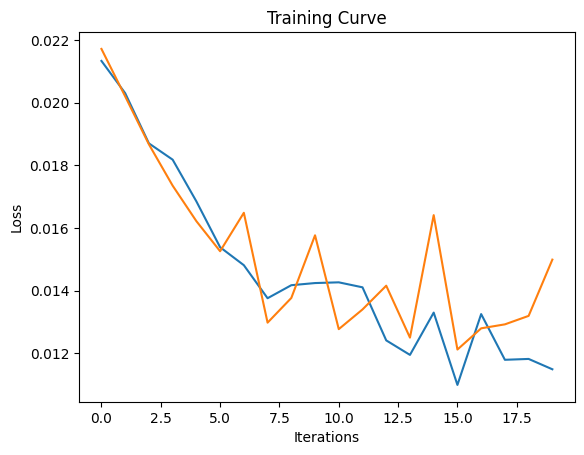

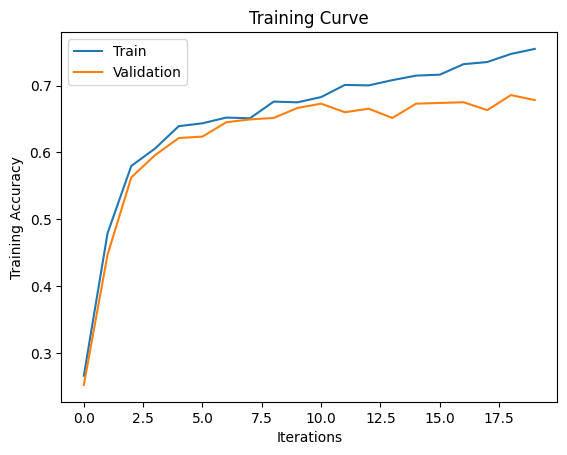

Final Training Accuracy: 0.7550874687611567
Final Validation Accuracy: 0.6784565916398714


In [170]:
model = CNNClassifier() # 7000 training images
train(model, train_dataset, val_dataset, batch_size=64, lr=0.0001, num_epochs=20)

Epoch 1: Train acc: 0.5198143520171368 | Validation acc: 0.5241157556270096
Epoch 2: Train acc: 0.5722956087111746 | Validation acc: 0.5852090032154341
Epoch 3: Train acc: 0.5865762227775795 | Validation acc: 0.6012861736334405
Epoch 4: Train acc: 0.6019278828989647 | Validation acc: 0.609860664523044
Epoch 5: Train acc: 0.6151374509103892 | Validation acc: 0.6077170418006431
Epoch 6: Train acc: 0.6251338807568726 | Validation acc: 0.6130760986066452
Epoch 7: Train acc: 0.6358443413066762 | Validation acc: 0.6227224008574491
Epoch 8: Train acc: 0.6433416636915388 | Validation acc: 0.6441586280814576
Epoch 9: Train acc: 0.6658336308461263 | Validation acc: 0.6463022508038585
Epoch 10: Train acc: 0.6601213852195644 | Validation acc: 0.6613076098606645
Epoch 11: Train acc: 0.6754730453409497 | Validation acc: 0.6570203644158628
Epoch 12: Train acc: 0.6826133523741521 | Validation acc: 0.6602357984994641
Epoch 13: Train acc: 0.7026062120671189 | Validation acc: 0.654876741693462
Epoch 14: 

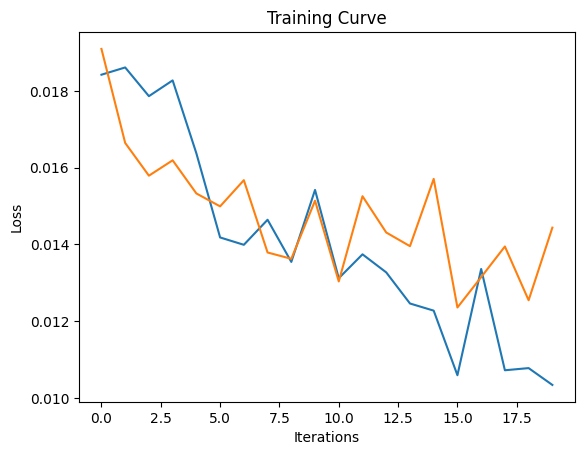

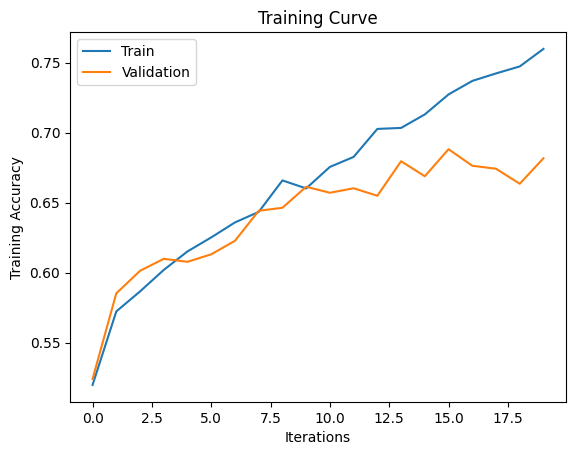

Final Training Accuracy: 0.7597286683327383
Final Validation Accuracy: 0.6816720257234726


In [164]:
model = CNNClassifier() # 7000 training images
train(model, train_dataset, val_dataset, batch_size=64, lr=0.0001, num_epochs=20)

In [ ]:
model = CNNClassifier() # 7000 training images
train(model, train_dataset, val_dataset, batch_size=64, lr=0.0001, num_epochs=20)

Epoch 1: Train acc: 0.5444484112816851 | Validation acc: 0.5594855305466238
Epoch 2: Train acc: 0.5533737950731882 | Validation acc: 0.564844587352626
Epoch 3: Train acc: 0.5740806854694752 | Validation acc: 0.5777063236870311
Epoch 4: Train acc: 0.5976436986790432 | Validation acc: 0.5980707395498392
Epoch 5: Train acc: 0.6169225276686897 | Validation acc: 0.6302250803858521
Epoch 6: Train acc: 0.6333452338450554 | Validation acc: 0.6334405144694534
Epoch 7: Train acc: 0.6515530167797215 | Validation acc: 0.6387995712754555
Epoch 8: Train acc: 0.6658336308461263 | Validation acc: 0.6559485530546624
Epoch 9: Train acc: 0.6786861835058907 | Validation acc: 0.6752411575562701
Epoch 10: Train acc: 0.6840414137807925 | Validation acc: 0.6645230439442658
Epoch 11: Train acc: 0.6872545519457337 | Validation acc: 0.6688102893890675
Epoch 12: Train acc: 0.7022491967154587 | Validation acc: 0.6806002143622722
Epoch 13: Train acc: 0.7097465191003213 | Validation acc: 0.6645230439442658
Epoch 14:

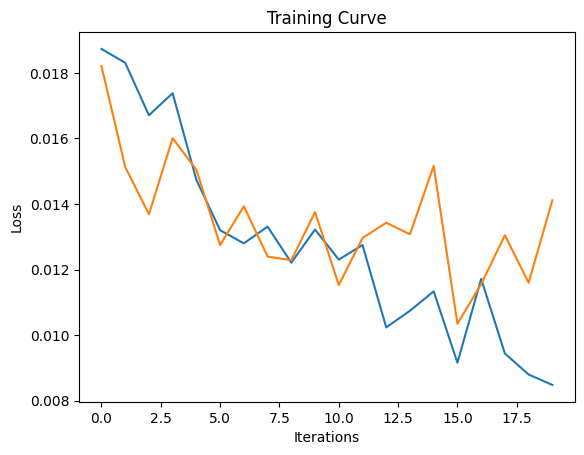

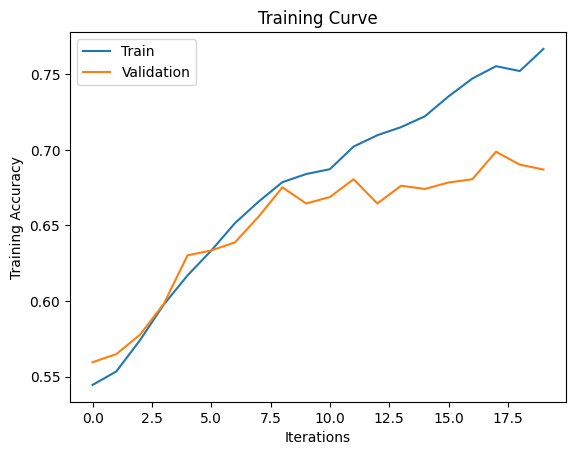

Final Training Accuracy: 0.7668689753659408
Final Validation Accuracy: 0.6870310825294748


In [161]:
model = CNNClassifier() # 7000 training images
train(model, train_dataset, val_dataset, batch_size=64, lr=0.0001, num_epochs=20)

Epoch 1: Train acc: 0.5565869332381292 | Validation acc: 0.5616291532690246
Epoch 2: Train acc: 0.5655123170296322 | Validation acc: 0.5744908896034298
Epoch 3: Train acc: 0.594073545162442 | Validation acc: 0.5905680600214362
Epoch 4: Train acc: 0.6101392359871475 | Validation acc: 0.6184351554126474
Epoch 5: Train acc: 0.6465548018564798 | Validation acc: 0.6366559485530546
Epoch 6: Train acc: 0.6604784005712245 | Validation acc: 0.6463022508038585
Epoch 7: Train acc: 0.670831845769368 | Validation acc: 0.6591639871382636
Epoch 8: Train acc: 0.6729739378793288 | Validation acc: 0.647374062165059
Epoch 9: Train acc: 0.6933238129239557 | Validation acc: 0.6645230439442658
Epoch 10: Train acc: 0.702963227418779 | Validation acc: 0.662379421221865
Epoch 11: Train acc: 0.7051053195287398 | Validation acc: 0.6720257234726688
Epoch 12: Train acc: 0.7243841485183863 | Validation acc: 0.6655948553054662
Epoch 13: Train acc: 0.7254551945733666 | Validation acc: 0.6602357984994641
Epoch 14: Tra

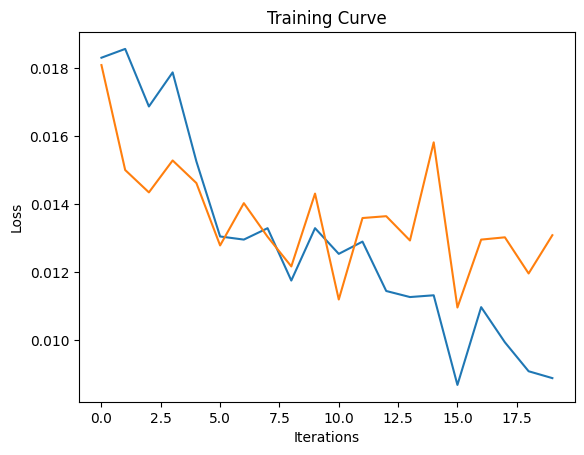

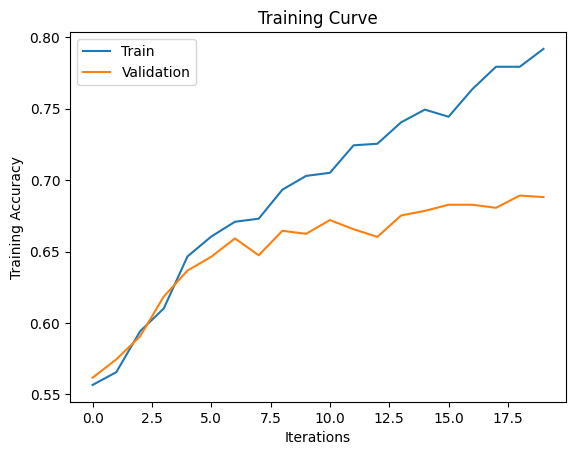

Final Training Accuracy: 0.7918600499821492
Final Validation Accuracy: 0.6881028938906752


In [159]:
model = CNNClassifier() # 7000 training images
train(model, train_dataset, val_dataset, batch_size=64, lr=0.0001, num_epochs=20)

Epoch 1: Train acc: 0.5444484112816851 | Validation acc: 0.5594855305466238
Epoch 2: Train acc: 0.5533737950731882 | Validation acc: 0.564844587352626
Epoch 3: Train acc: 0.5740806854694752 | Validation acc: 0.5777063236870311
Epoch 4: Train acc: 0.5976436986790432 | Validation acc: 0.5980707395498392
Epoch 5: Train acc: 0.6169225276686897 | Validation acc: 0.6302250803858521
Epoch 6: Train acc: 0.6333452338450554 | Validation acc: 0.6334405144694534
Epoch 7: Train acc: 0.6515530167797215 | Validation acc: 0.6387995712754555
Epoch 8: Train acc: 0.6658336308461263 | Validation acc: 0.6559485530546624
Epoch 9: Train acc: 0.6786861835058907 | Validation acc: 0.6752411575562701
Epoch 10: Train acc: 0.6840414137807925 | Validation acc: 0.6645230439442658
Epoch 11: Train acc: 0.6872545519457337 | Validation acc: 0.6688102893890675
Epoch 12: Train acc: 0.7022491967154587 | Validation acc: 0.6806002143622722
Epoch 13: Train acc: 0.7097465191003213 | Validation acc: 0.6645230439442658
Epoch 14:

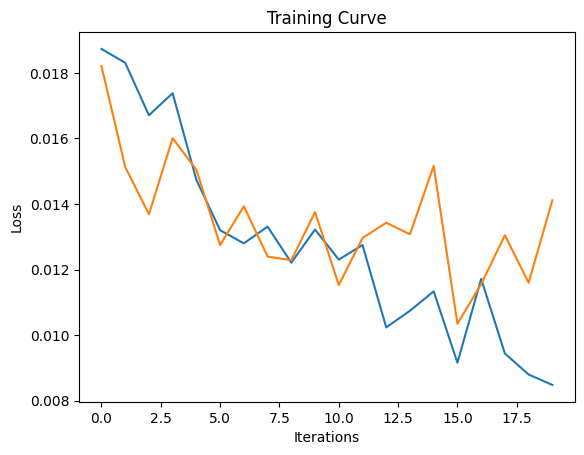

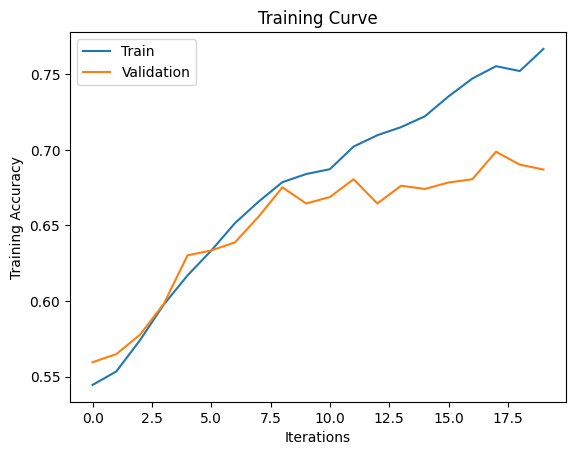

Final Training Accuracy: 0.7668689753659408
Final Validation Accuracy: 0.6870310825294748


In [155]:
model = CNNClassifier() # 7000 training images
train(model, train_dataset, val_dataset, batch_size=64, lr=0.0001, num_epochs=20)

Epoch 1: Train acc: 0.555872902534809 | Validation acc: 0.5541264737406216
Epoch 2: Train acc: 0.5694394858978936 | Validation acc: 0.579849946409432
Epoch 3: Train acc: 0.5890753302392003 | Validation acc: 0.5927116827438371
Epoch 4: Train acc: 0.6165655123170296 | Validation acc: 0.6237942122186495
Epoch 5: Train acc: 0.6337022491967155 | Validation acc: 0.6334405144694534
Epoch 6: Train acc: 0.6533380935380221 | Validation acc: 0.6334405144694534
Epoch 7: Train acc: 0.6740449839343092 | Validation acc: 0.6463022508038585
Epoch 8: Train acc: 0.67654409139593 | Validation acc: 0.6420150053590568
Epoch 9: Train acc: 0.6886826133523741 | Validation acc: 0.6645230439442658
Epoch 10: Train acc: 0.694394858978936 | Validation acc: 0.662379421221865
Epoch 11: Train acc: 0.7047483041770796 | Validation acc: 0.6709539121114684
Epoch 12: Train acc: 0.7065333809353802 | Validation acc: 0.6580921757770632
Epoch 13: Train acc: 0.7190289182434845 | Validation acc: 0.662379421221865
Epoch 14: Train

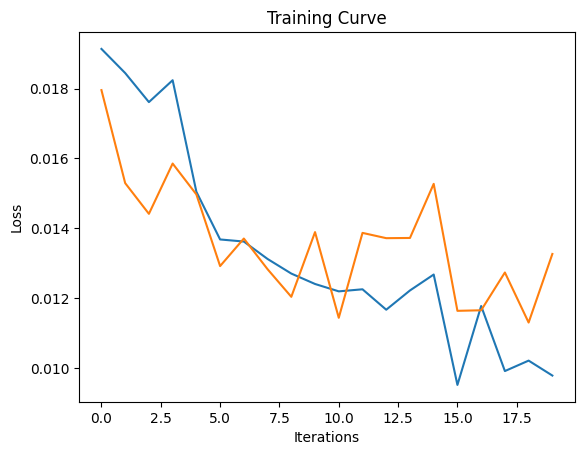

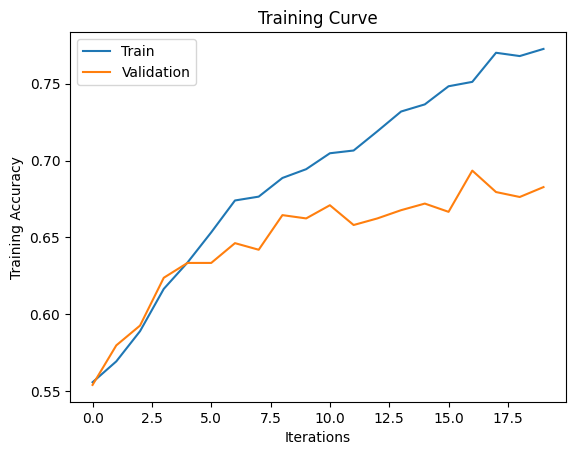

Final Training Accuracy: 0.7725812209925027
Final Validation Accuracy: 0.6827438370846731


In [152]:
model = CNNClassifier() # 7000 training images
train(model, train_dataset, val_dataset, batch_size=64, lr=0.0001, num_epochs=20)

Epoch 1: Train acc: 0.5630132095680114 | Validation acc: 0.5637727759914255
Epoch 2: Train acc: 0.5990717600856836 | Validation acc: 0.602357984994641
Epoch 3: Train acc: 0.6254908961085327 | Validation acc: 0.6259378349410504
Epoch 4: Train acc: 0.6404855408782578 | Validation acc: 0.639871382636656
Epoch 5: Train acc: 0.6636915387361657 | Validation acc: 0.6495176848874598
Epoch 6: Train acc: 0.6754730453409497 | Validation acc: 0.6613076098606645
Epoch 7: Train acc: 0.685112459835773 | Validation acc: 0.654876741693462
Epoch 8: Train acc: 0.6983220278471974 | Validation acc: 0.6570203644158628
Epoch 9: Train acc: 0.7111745805069618 | Validation acc: 0.6655948553054662
Epoch 10: Train acc: 0.720456979650125 | Validation acc: 0.6688102893890675
Epoch 11: Train acc: 0.7375937165298108 | Validation acc: 0.6688102893890675
Epoch 12: Train acc: 0.7375937165298108 | Validation acc: 0.6806002143622722
Epoch 13: Train acc: 0.7572295608711175 | Validation acc: 0.6666666666666666
Epoch 14: Tra

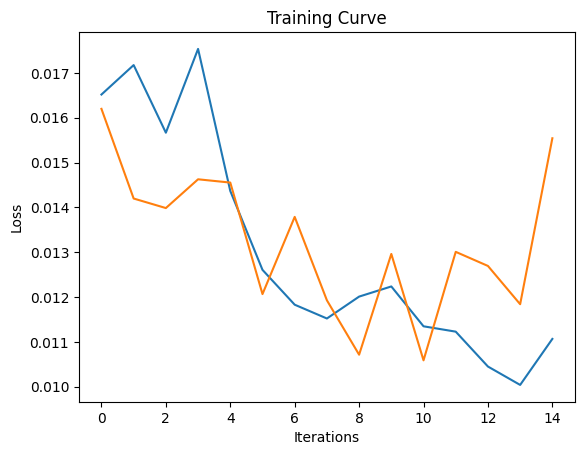

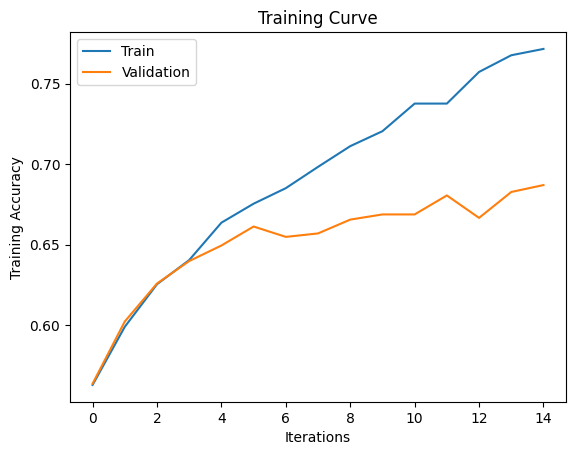

Final Training Accuracy: 0.7715101749375223
Final Validation Accuracy: 0.6870310825294748


In [149]:
model = CNNClassifier() # 7000 training images
train(model, train_dataset, val_dataset, batch_size=64, lr=0.0001, num_epochs=15)

Epoch 1: Train acc: 0.4183723797780518 | Validation acc: 0.41770263550472403
Epoch 2: Train acc: 0.4879161528976572 | Validation acc: 0.48085529587270015
Epoch 3: Train acc: 0.544019728729963 | Validation acc: 0.5320735952262556
Epoch 4: Train acc: 0.5966707768187423 | Validation acc: 0.5852809547488812
Epoch 5: Train acc: 0.6394574599260172 | Validation acc: 0.6245648930880159
Epoch 6: Train acc: 0.6627620221948212 | Validation acc: 0.6469418199900547
Epoch 7: Train acc: 0.6960542540073983 | Validation acc: 0.6633515663848831
Epoch 8: Train acc: 0.7094944512946979 | Validation acc: 0.6827449030333168
Epoch 9: Train acc: 0.7374845869297164 | Validation acc: 0.6911984087518648
Epoch 10: Train acc: 0.7575832305795315 | Validation acc: 0.6894579811039284
Epoch 11: Train acc: 0.7802712700369914 | Validation acc: 0.707856787667827
Epoch 12: Train acc: 0.801233045622688 | Validation acc: 0.71730482347091
Epoch 13: Train acc: 0.8255240443896424 | Validation acc: 0.7347090999502734
Epoch 14: T

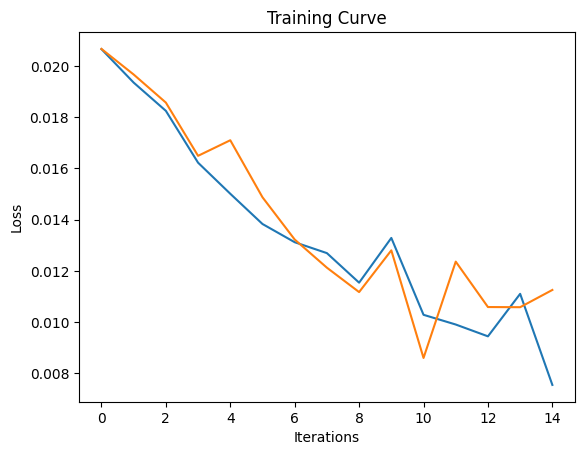

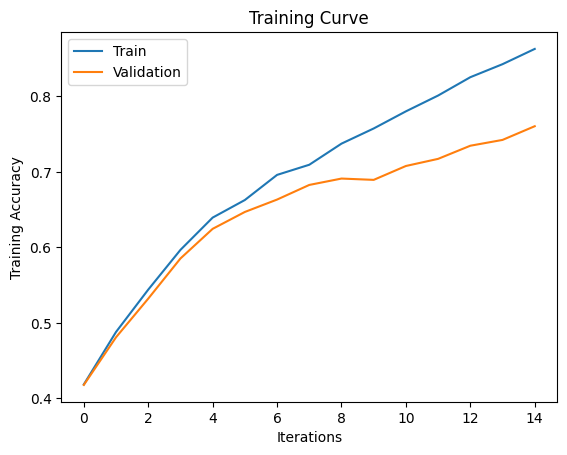

Final Training Accuracy: 0.8630086313193588
Final Validation Accuracy: 0.760566882148185


In [143]:
model = CNNClassifier() # 7000 training images
train(model, train_dataset, val_dataset, batch_size=64, lr=0.0001, num_epochs=15)

Epoch 1: Train acc: 0.5236744759556103 | Validation acc: 0.5196419691695674
Epoch 2: Train acc: 0.5991368680641184 | Validation acc: 0.587518647439085
Epoch 3: Train acc: 0.649075215782984 | Validation acc: 0.6215813028344107
Epoch 4: Train acc: 0.6785450061652281 | Validation acc: 0.6548980606663352
Epoch 5: Train acc: 0.7094944512946979 | Validation acc: 0.6703132769766286
Epoch 6: Train acc: 0.7292231812577066 | Validation acc: 0.6815017404276479
Epoch 7: Train acc: 0.7525277435265105 | Validation acc: 0.6991546494281452
Epoch 8: Train acc: 0.7726263871763255 | Validation acc: 0.7036300348085529
Epoch 9: Train acc: 0.7907521578298397 | Validation acc: 0.724763799104923
Epoch 10: Train acc: 0.8113440197287299 | Validation acc: 0.7272501243162606
Epoch 11: Train acc: 0.826387176325524 | Validation acc: 0.7401790154152164
Epoch 12: Train acc: 0.8480887792848335 | Validation acc: 0.7439085032322228
Epoch 13: Train acc: 0.862268803945746 | Validation acc: 0.7637991049229239
Epoch 14: Tra

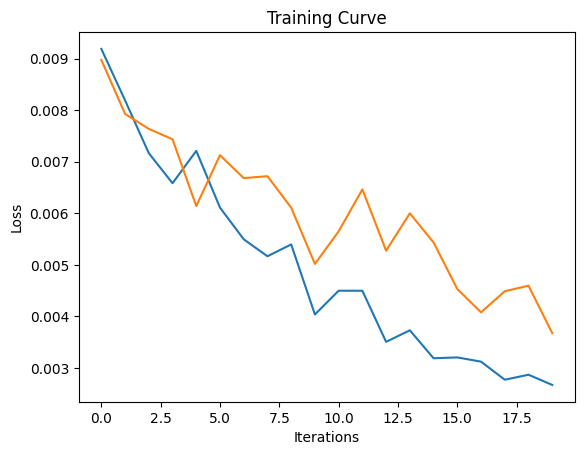

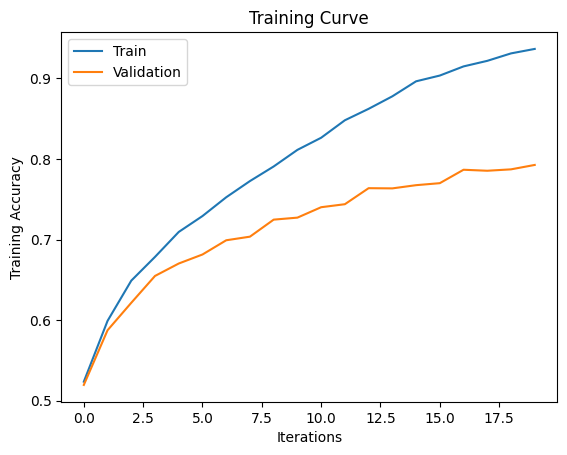

Final Training Accuracy: 0.9366214549938348
Final Validation Accuracy: 0.7926404773744405


In [139]:
model_cnn_5 = CNNClassifier() # 7000 training images
train(model_cnn_5, train_dataset, val_dataset, batch_size=128, lr=0.00001, num_epochs=20)

In [207]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "cnn"
        # Input shape [128, 512, 7, 7] == [batch size, channels, feature map width, fm height]
        self.conv1 = nn.Conv2d(512, 256, 3, padding=1)  # Output: [batch, 128, 7, 7]
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer : 256 * 4 * 4
        self.bn1 = nn.BatchNorm2d(256)
        self.cbam1 = CBAM(256)
        
        self.conv2 = nn.Conv2d(256, 128, 3, padding=1)  # Output: [batch, 128, 4, 4]
        self.bn2 = nn.BatchNorm2d(128)
        self.cbam2 = CBAM(128)
        
        self.conv3 = nn.Conv2d(128, 64, 3, padding=1)  # Output: [batch, 64, 4, 4]
        
        self.dropout = nn.Dropout(0.5)

        self.fc = nn.Linear(128, 16)
        self.fc1 = nn.Linear(16, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.cbam1(x)
        x = self.dropout(x)
        
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.cbam2(x)
        
       # x = self.pool(self.conv3(x))
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = self.fc1(F.relu(self.fc(x))) # Fully connected layer
        return x

Epoch 1: Train acc: 0.3044665012406948 | Validation acc: 0.30414746543778803
Epoch 2: Train acc: 0.33829611248966085 | Validation acc: 0.3407712830463255
Epoch 3: Train acc: 0.3700578990901571 | Validation acc: 0.36526800873150617
Epoch 4: Train acc: 0.38899917287014063 | Validation acc: 0.38127577007033714
Epoch 5: Train acc: 0.40297766749379654 | Validation acc: 0.3967984477322338
Epoch 6: Train acc: 0.40703060380479733 | Validation acc: 0.41183604171719623
Epoch 7: Train acc: 0.419520264681555 | Validation acc: 0.4137763764249333
Epoch 8: Train acc: 0.42597187758478083 | Validation acc: 0.41256366723259763
Epoch 9: Train acc: 0.43746898263027295 | Validation acc: 0.42711617754062575
Epoch 10: Train acc: 0.4431761786600496 | Validation acc: 0.42978413776376423
Epoch 11: Train acc: 0.4525227460711332 | Validation acc: 0.43730293475624543
Epoch 12: Train acc: 0.45161290322580644 | Validation acc: 0.4462769827795295
Epoch 13: Train acc: 0.4663358147229115 | Validation acc: 0.45694882367

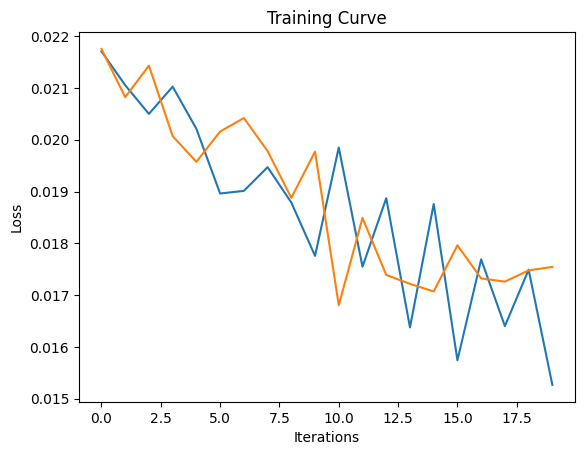

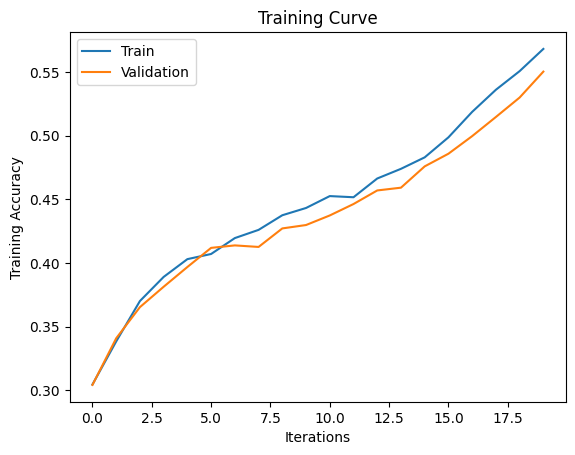

Final Training Accuracy: 0.5681555004135649
Final Validation Accuracy: 0.5503274314819306


In [211]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=64, lr=0.0001, num_epochs=20)

Epoch 1: Train acc: 0.18492074825074967 | Validation acc: 0.16709511568123395
Epoch 2: Train acc: 0.2316150221333714 | Validation acc: 0.23864610111396745
Epoch 3: Train acc: 0.2808796230187063 | Validation acc: 0.29605826906598115
Epoch 4: Train acc: 0.3577038412109096 | Validation acc: 0.356898029134533
Epoch 5: Train acc: 0.40111380836784233 | Validation acc: 0.4104541559554413
Epoch 6: Train acc: 0.4432386120234185 | Validation acc: 0.4502999143101971
Epoch 7: Train acc: 0.4829358846208768 | Validation acc: 0.47986289631533846
Epoch 8: Train acc: 0.502927316864201 | Validation acc: 0.4987146529562982
Epoch 9: Train acc: 0.5303441382264744 | Validation acc: 0.5299914310197087
Epoch 10: Train acc: 0.5343424246751393 | Validation acc: 0.5501285347043702
Epoch 11: Train acc: 0.5530486934171069 | Validation acc: 0.5548414738646101
Epoch 12: Train acc: 0.5567613879765815 | Validation acc: 0.5616966580976864
Epoch 13: Train acc: 0.5634727973725546 | Validation acc: 0.5715509854327335
Epoc

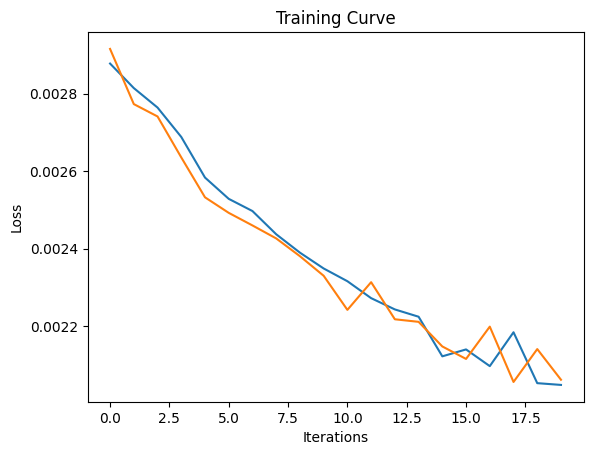

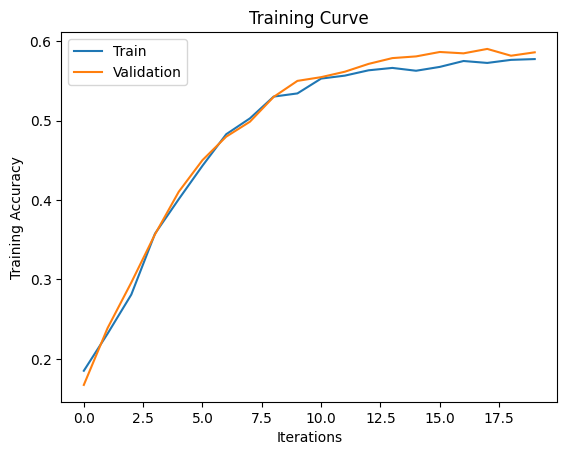

Final Training Accuracy: 0.5776095958874768
Final Validation Accuracy: 0.5861182519280206


In [129]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=512, lr=0.0001, num_epochs=20)

Epoch 1: Train acc: 0.41253748393545625 | Validation acc: 0.390745501285347
Epoch 2: Train acc: 0.5504783664143938 | Validation acc: 0.5548414738646101
Epoch 3: Train acc: 0.5537626731400829 | Validation acc: 0.5629820051413882
Epoch 4: Train acc: 0.5616164500928174 | Validation acc: 0.577120822622108
Epoch 5: Train acc: 0.5743252891617878 | Validation acc: 0.5938303341902313
Epoch 6: Train acc: 0.5890332714550907 | Validation acc: 0.6131105398457584
Epoch 7: Train acc: 0.607453948307868 | Validation acc: 0.6148243359040274
Epoch 8: Train acc: 0.6185920319862915 | Validation acc: 0.6306769494430163
Epoch 9: Train acc: 0.6281593602741682 | Validation acc: 0.6311053984575835
Epoch 10: Train acc: 0.6314436669998572 | Validation acc: 0.6379605826906598
Epoch 11: Train acc: 0.6420105668999 | Validation acc: 0.6456726649528706
Epoch 12: Train acc: 0.6465800371269456 | Validation acc: 0.6542416452442159
Epoch 13: Train acc: 0.648579180351278 | Validation acc: 0.6491002570694088
Epoch 14: Trai

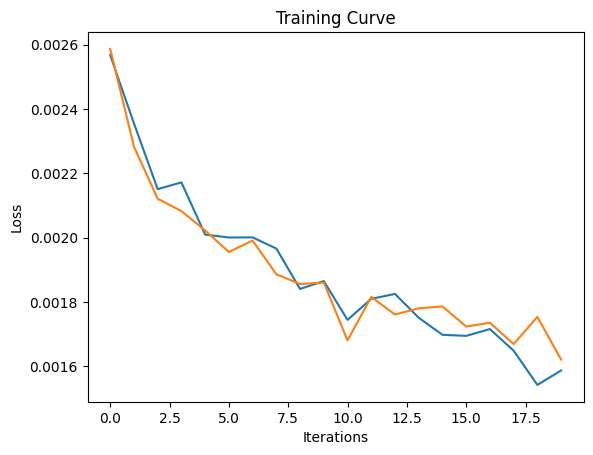

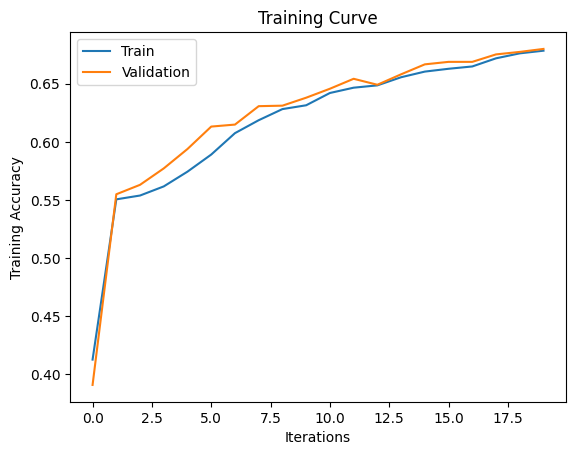

Final Training Accuracy: 0.6784235327716693
Final Validation Accuracy: 0.6799485861182519


In [130]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=512, lr=0.001, num_epochs=20)

In [131]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=512, lr=0.001, num_epochs=50)

Epoch 1: Train acc: 0.41253748393545625 | Validation acc: 0.390745501285347
Epoch 2: Train acc: 0.5504783664143938 | Validation acc: 0.5548414738646101
Epoch 3: Train acc: 0.5537626731400829 | Validation acc: 0.5629820051413882
Epoch 4: Train acc: 0.5616164500928174 | Validation acc: 0.577120822622108
Epoch 5: Train acc: 0.5743252891617878 | Validation acc: 0.5938303341902313
Epoch 6: Train acc: 0.5890332714550907 | Validation acc: 0.6131105398457584
Epoch 7: Train acc: 0.607453948307868 | Validation acc: 0.6148243359040274
Epoch 8: Train acc: 0.6185920319862915 | Validation acc: 0.6306769494430163
Epoch 9: Train acc: 0.6281593602741682 | Validation acc: 0.6311053984575835
Epoch 10: Train acc: 0.6314436669998572 | Validation acc: 0.6379605826906598
Epoch 11: Train acc: 0.6420105668999 | Validation acc: 0.6456726649528706
Epoch 12: Train acc: 0.6465800371269456 | Validation acc: 0.6542416452442159
Epoch 13: Train acc: 0.648579180351278 | Validation acc: 0.6491002570694088
Epoch 14: Trai

KeyboardInterrupt: 

In [44]:

def train(model, data, val_data=None, trial_num=0, batch_size=1, lr=0.01, num_epochs=10):
    torch.manual_seed(1000)

    if use_cuda and torch.cuda.is_available():
        model.cuda()

    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr, weight_decay=1e-4)

    iters, train_loss, val_loss, train_acc, val_acc = [], [], [], [], []

    start_time = time.time()

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in data_loader:
            #print(imgs.shape)
            #print(labels)
            #print("Image shape before: ", imgs.shape)
            #imgs = imgs.squeeze(0)
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            labels = labels.squeeze()

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        for imgs, labels in val_loader:
            #print(imgs.shape)
            #print(labels)
            #print("Image shape before: ", imgs.shape)
            #imgs = imgs.squeeze(0)
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            labels = labels.squeeze()

            out = model(imgs)             # forward pass
            v_loss = criterion(out, labels) # compute the total loss


        # save the current training information
        iters.append(n)
        train_loss.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, data, batch_size=batch_size)) # compute training accuracy


        val_acc.append(get_accuracy(model, val_data, batch_size=batch_size))  # compute validation accuracy
        val_loss.append(float(v_loss)/batch_size)
        n += 1


        if val_data != None:
            print(f"Epoch {epoch + 1}: Train acc: {train_acc[-1]} | Validation acc: {val_acc[-1]}")
        else:
            print(f"Epoch {epoch + 1}: Train acc: {train_acc[-1]}")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time elapsed: {elapsed_time:.2f} s")

    # plot
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.plot(iters, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    if val_data != None:
        print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [45]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "cnn"
        # Input shape [128, 512, 7, 7] == [batch size, channels, feature map width, fm height]
        self.conv1 = nn.Conv2d(512, 256, 3, padding=1)  # Output: [batch, 128, 7, 7]
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer : 256 * 4 * 4
        self.bn1 = nn.BatchNorm2d(256)
        self.cbam1 = CBAM(256)
        
        self.conv2 = nn.Conv2d(256, 128, 3, padding=1)  # Output: [batch, 128, 4, 4]
        self.bn2 = nn.BatchNorm2d(128)
        self.cbam2 = CBAM(128)
        
        self.conv3 = nn.Conv2d(128, 64, 3, padding=1)  # Output: [batch, 64, 4, 4]
        
        self.dropout = nn.Dropout(0.5)

        self.fc = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.cbam1(x)
        x = self.dropout(x)
        
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.cbam2(x)
        
       # x = self.pool(self.conv3(x))
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = self.fc(x)  # Fully connected layer
        return x

Epoch 1: Train acc: 0.5369482559100678 | Validation acc: 0.5249878699660359
Epoch 2: Train acc: 0.5926599437923624 | Validation acc: 0.5803008248423096
Epoch 3: Train acc: 0.6510166969747065 | Validation acc: 0.6055312954876274
Epoch 4: Train acc: 0.6877169780128947 | Validation acc: 0.6322173702086366
Epoch 5: Train acc: 0.7288808067449165 | Validation acc: 0.6302765647743813
Epoch 6: Train acc: 0.7599603240204993 | Validation acc: 0.5992236778262979
Epoch 7: Train acc: 0.7607869069267648 | Validation acc: 0.6118389131489568
Epoch 8: Train acc: 0.7971565548024467 | Validation acc: 0.6132945172246482
Epoch 9: Train acc: 0.8194742932716151 | Validation acc: 0.5958272683163512
Epoch 10: Train acc: 0.8429492478095553 | Validation acc: 0.6142649199417758
Total time elapsed: 200.57 s


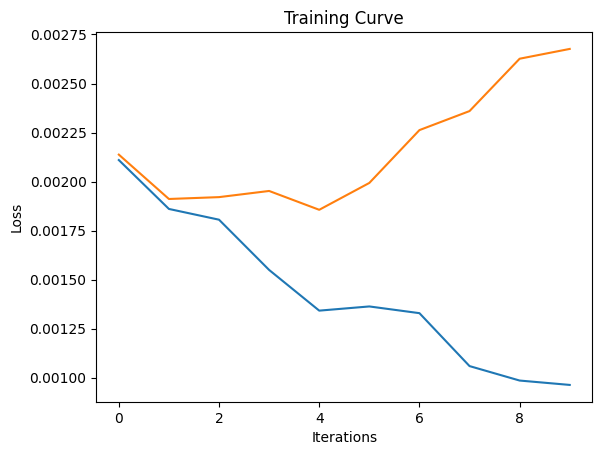

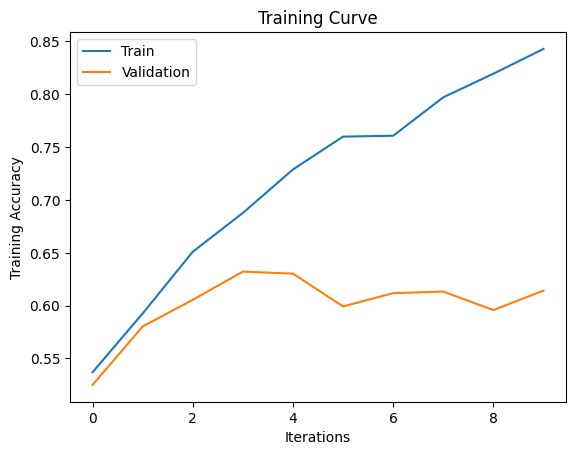

Final Training Accuracy: 0.8429492478095553
Final Validation Accuracy: 0.6142649199417758


In [46]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=512, lr=0.01, num_epochs=10)

In [61]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "cnn"
        # Input shape [128, 512, 7, 7] == [batch size, channels, feature map width, fm height]
        self.conv1 = nn.Conv2d(512, 128, 3, padding=1)  # Output: [batch, 128, 7, 7]
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer : 256 * 4 * 4
        self.bn1 = nn.BatchNorm2d(128)
        self.cbam1 = CBAM(128)
        
        self.conv2 = nn.Conv2d(128, 64, 3, padding=1)  # Output: [batch, 128, 4, 4]
        self.bn2 = nn.BatchNorm2d(64)
        self.cbam2 = CBAM(64)
        
        self.conv3 = nn.Conv2d(128, 64, 3, padding=1)  # Output: [batch, 64, 4, 4]
        
       # self.dropout = nn.Dropout(0.3)

        self.fc = nn.Linear(64, 4)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        #x = self.dropout(x)
        
        x = self.pool(self.conv2(x))
        x = self.cbam2(x)
      #  x = self.dropout(x)
        
       # x = self.pool(self.conv3(x))
        # x = self.dropout(x)
        
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = self.fc(x)  # Fully connected layer
        return x

In [69]:
val_dataset = train_dataset + test_dataset
train_dataset = train_dataset + test_dataset

In [70]:
model_cnn_6 = CNNClassifier() # 7000 training images
train(model_cnn_6, train_dataset, val_dataset, batch_size=64, lr=0.001, num_epochs=10)

Epoch 1: Train acc: 0.6589263420724095 | Validation acc: 0.6589263420724095


KeyboardInterrupt: 